In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from matplotlib_venn import venn2
from statannot import add_stat_annotation 

In [2]:
#colors
sns.set(style="whitegrid")
bgi_main = '#5eaab3'
bgi_lght = '#aacfd5'
ill_main = '#ee7339'
shared_cl = '#94a577'
shared_cl1 = '#b1c295'
main_cl = '#1c4e9c'

In [4]:
def clean_df(df, shared_smpls):
    
    df = df.copy()
    # Filter out genes < 2
    df[df < 2] = 0
    col_sums = df.sum()
    df.divide(col_sums) * 100

    # Keep only shared samples
    df = df[df.columns.intersection(shared_smpls)]

    # Drop rows and columns that contain only zeros
    df = df.loc[~(df == 0).all(axis=1)]  
    df = df.loc[:, ~(df == 0).all(axis=0)] 

from numpy import mean
from numpy import var
from math import sqrt

def cohend(d1,d2):
    n1, n2 = len(d1), len(d2)
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = mean(d1), mean(d2)
    return (u1 - u2) / s

In [9]:
# read the data
bgi_df1 = pd.read_csv("input/bgi_mifiser_merged.tsv", sep="\t", index_col=0).astype(float)
bgi_df2 = pd.read_csv("input/bgi_mifiser_around50_merged.tsv", sep="\t", index_col=0).astype(float)
bgi_df = pd.merge(bgi_df1, bgi_df2, left_index=True, right_index=True, how='outer').fillna(0)
bgi_df.columns = bgi_df.columns.str.replace('bgi_', '')

ill_df1 = pd.read_csv("input/ill_mifiser_merged.tsv", sep="\t", index_col=0).astype(float)
ill_df2 = pd.read_csv("input/ill_mifiser_around50_merged.tsv", sep="\t", index_col=0).astype(float)
ill_df = pd.merge(ill_df1, ill_df2, left_index=True, right_index=True, how='outer').fillna(0)

shared_smpls = set(ill_df.columns) & set(bgi_df.columns)

clean_df(bgi_df1, shared_smpls)
clean_df(ill_df1, shared_smpls)

print("Number of MGI samples: ", len(bgi_df.columns), "number of genes detected: ", len(bgi_df))
print("Number of MGI samples: ", len(bgi_df.columns), "number of genes detected: ", len(ill_df))
print("Total number of genes: ", len(set(bgi_df.index) | set(ill_df.index)))
print("Platform-unique genes: ", len((set(bgi_df.index) - set(ill_df.index))) + len((set(ill_df.index) - set(bgi_df.index))))
print("Number of MGI samples: ", len(shared_smpls))

42/1192*100

Number of MGI samples:  200 number of genes detected:  1188
Number of MGI samples:  200 number of genes detected:  1154
Total number of genes:  1192
Platform-unique genes:  42
Number of MGI samples:  200


3.523489932885906

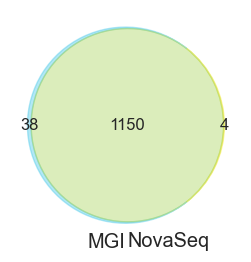

In [150]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Create a Venn diagram
plt.figure(figsize=(3, 3))
venn = venn2(subsets=(set(bgi_df.index), set(ill_df.index)),
             set_labels=('MGI', 'NovaSeq'))
venn.get_patch_by_id('10').set_color('#43c7e8')
venn.get_patch_by_id('01').set_color('#f5e50c')
venn.get_patch_by_id('11').set_color('#a5d455')

plt.savefig("results/Figure_5/Fig5a.png", dpi=300, bbox_inches='tight')
plt.savefig("results/Figure_5/Fig5a.svg", bbox_inches='tight')

plt.show()

In [151]:
bgi_only = []
ill_only = []
bgi_only_counts = []
ill_only_counts = []
shared = []
shared_counts = []
x_names = []
bottom_list = []

for a in shared_smpls:
    try:
        sample_bgi_only = 0
        sample_ill_only = 0
        sample_shared = 0
        in_bgi = list(bgi_df.loc[bgi_df[a] > 0].index)
        in_ill = list(ill_df.loc[ill_df[a] > 0].index)
        all_found = list(set(in_bgi + in_ill))
        for b in all_found:
            if b in in_bgi and b not in in_ill:
                sample_bgi_only += 1
            elif b not in in_bgi and b in in_ill:
                sample_ill_only += 1
            else: # b in in_bgi and b in in_ill:
                sample_shared += 1
        bgi_only.append(sample_bgi_only/len(all_found))
        ill_only.append(sample_ill_only/len(all_found))
        bgi_only_counts.append(sample_bgi_only)
        ill_only_counts.append(sample_ill_only)
        shared.append(sample_shared/len(all_found))
        shared_counts.append(sample_shared)
        bottom_list.append(sample_bgi_only/len(all_found) + sample_shared/len(all_found))
        x_names.append(a)
    except:
        print(a)

stacked_df = pd.DataFrame(columns = ['bgi','shared','ill','sample','bottom'])
stacked_df['bgi'] = bgi_only
stacked_df['ill'] = ill_only
stacked_df['shared'] = shared
stacked_df['bgi_counts'] = bgi_only_counts
stacked_df['ill_counts'] = ill_only_counts
stacked_df['shared_counts'] = shared_counts
stacked_df['sample'] = x_names
stacked_df['bottom'] = bottom_list
stacked_df = stacked_df.sort_values(by="shared", ascending=False)
stacked_df = stacked_df.loc[stacked_df['shared'] >= 0.5]
stacked_df['sample_no'] = np.linspace(1,len(list(stacked_df['bgi'])),len(list(stacked_df['bgi'])))

print(stacked_df.shape)

stacked_df.to_csv("Stacked_df_functions_overlap.txt", sep="\t", index=False)

good_samples = list(stacked_df['sample'])[:100]
bad_samples = list(stacked_df['sample'])[100:]


(200, 9)


In [152]:
stacked_df.head(2)

,bgi,shared,ill,sample,bottom,bgi_counts,ill_counts,shared_counts,sample_no
81,0.032000,0.961000,0.00700,VGXMGU,0.99300,32,7,961,1.0
8,0.030864,0.960905,0.00823,VV3NTG,0.99177,30,8,934,2.0


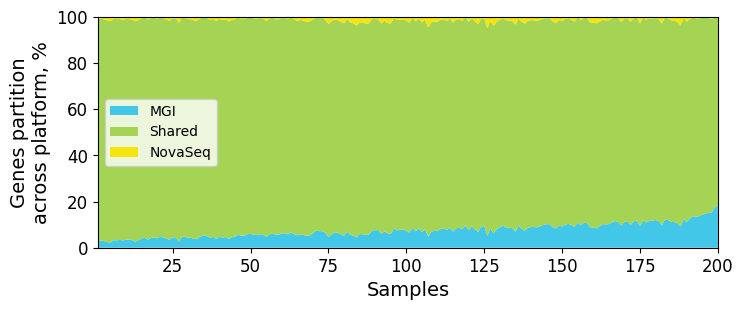

In [153]:
plt.figure(figsize=(8,3))
sns.set_style('white')
sns.reset_defaults()
plt.stackplot(stacked_df.sample_no, stacked_df.bgi, stacked_df.shared, stacked_df.ill, labels=['MGI', 'Shared','NovaSeq'], colors=['#43c7e8', '#a5d455', '#f5e50c'])
plt.legend(loc='center left') #bbox_to_anchor=(1.1, 1.0))
plt.xlabel("Samples", fontsize=14)
plt.ylabel("Genes partition\nacross platform, %", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks([0,0.2,0.4,0.6,0.8,1], labels=[0,20,40,60,80,100],fontsize=12)
plt.xlim([1,200])
plt.ylim([0,1])

plt.savefig("results/Figure_5/Fig5d.png", dpi=300, bbox_inches='tight')
plt.savefig("results/Figure_5/Fig5d.svg", bbox_inches='tight')

plt.show()

91.09670674098058
2.9741867232876507


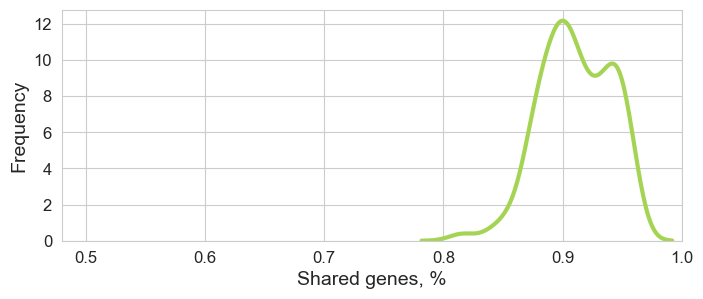

In [154]:
plt.figure(figsize=(8,3))
sns.set_style("whitegrid")

sns.kdeplot(list(stacked_df.sort_values(by='shared', ascending=True)['shared']), color='#a5d455', linewidth=3) 
plt.grid()
#plt.title("Distribution of the fraction of shared species")
plt.ylabel("Frequency", fontsize=14)
plt.xlabel("Shared genes, %", fontsize=14)
plt.xlim(0.48, 1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().invert_xaxis()
plt.grid()

print(stacked_df['shared'].mean()*100)
print(stacked_df['shared'].std()*100)

plt.savefig("results/Figure_5/Fig5e.png", dpi=300, bbox_inches='tight')
plt.savefig("results/Figure_5/Fig5e.svg", bbox_inches='tight')

plt.show()

In [155]:
# Calculate the number of genes for MGI and NovaSeq using vectorized operations
mgi_vals = (bgi_df > 0).sum(axis=0)
ill_vals = (ill_df > 0).sum(axis=0)

gn_numb = pd.DataFrame({'MGI': mgi_vals, 'NovaSeq': ill_vals})
print("MGI mean species per sample: ", gn_numb['MGI'].mean().round(1))
print("NovaSeq mean species per sample: ", gn_numb['NovaSeq'].mean().round(1))
gn_numb.head(2)

MGI mean species per sample:  948.4
NovaSeq mean species per sample:  889.6


,MGI,NovaSeq
V045JG,875,821
V06KFU,937,862


In [156]:
# Calculate deltas (differences between paired samples)
gn_numb['delta'] = gn_numb['MGI'] - gn_numb['NovaSeq']

# Test normality
from scipy.stats import shapiro
shapiro(gn_numb['delta'])

from scipy.stats import wilcoxon
stat, p = wilcoxon(gn_numb['MGI'], gn_numb['NovaSeq'])
#print("Wilcoxon test statistic:", stat)
if p<0.05:
    print("Nope, it's significantly not normal, p-value:", p)
    # OR Wilcoxon test
    from scipy.stats import wilcoxon
    stat, p_val = wilcoxon(gn_numb['MGI'], gn_numb['NovaSeq'])
    print("Paired wilcoxon p-value:", p_val)
else:
    print("It is normal, p-value:", p)
    # Paired t-test
    from scipy.stats import ttest_rel
    t_stat, p_val = ttest_rel(gn_numb['MGI'], gn_numb['NovaSeq'])
    print("Paired t-test p-value:", p_val)

#Quantify Effect Size
print("absolute difference between two means ", (gn_numb['MGI'].mean() - gn_numb['NovaSeq'].mean()).round(2))
print("Cohen's d ≈ ", cohend(gn_numb['MGI'],gn_numb['NovaSeq']).round(2))

Nope, it's significantly not normal, p-value: 2.0853521705360445e-34
Paired wilcoxon p-value: 2.0853521705360445e-34
absolute difference between two means  58.76
Cohen's d ≈  1.15


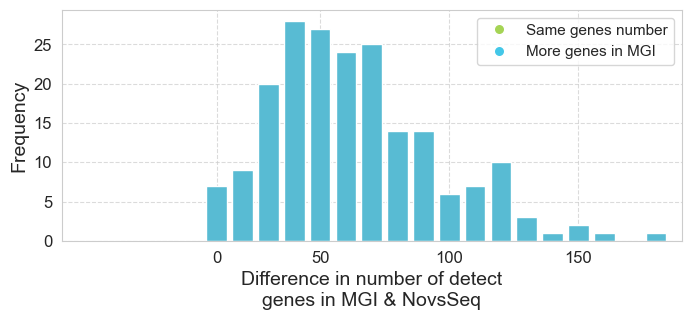

In [157]:
# plot the diferences
cnts = gn_numb['delta'].value_counts().to_frame()
cnts = cnts.reindex(range(-10, 180), fill_value=0)
cnts = cnts.reset_index()  
cnts = cnts.sort_values(by='index')
# aggregation
cnts['window'] = (cnts['index'] // 10) * 10
cnts_df = cnts.groupby('window')['delta'].sum().reset_index()
cnts_df = cnts_df.set_index('window')
        
# 3. Plot the boxplot
sns.set_style("whitegrid")
plt.figure(figsize=(8, 3))
ax = sns.barplot(x=cnts_df.index, y='delta', data=cnts_df, color='#43c7e8')

# Define which ticks to show
ticks_to_show = [0, 50, 100, 150]
tick_positions = [1,5, 10, 15]
ax.set_xticks(tick_positions)
ax.set_xticklabels([str(t) for t in ticks_to_show])

plt.xlabel('Difference in number of detect\ngenes in MGI & NovsSeq', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-5, 19)
#plt.text(1, 10, f'Mean: {np.mean(gn_numb["delta_bin"]):.2f}\nStd: {np.std(gn_numb["delta"]):.2f}', fontsize=11, color='black')

# Create custom legend handles
from matplotlib.lines import Line2D
legend_elements = [

    Line2D([0], [0], marker='o', color='w', label='Same genes number', markerfacecolor="#a5d455", markersize=5),
	Line2D([0], [0], marker='o', color='w', label='More genes in MGI', markerfacecolor='#43c7e8', markersize=5)
]

# Add the custom legend
plt.legend(handles=legend_elements, loc='upper right', fontsize=11, markerscale=1.5)
plt.grid(linestyle='--', alpha=0.7)

plt.savefig("results/Figure_5/Fig5b.png", dpi=300, bbox_inches='tight')
plt.savefig("results/Figure_5/Fig5b.svg", bbox_inches='tight')

plt.show()


In [11]:
from pathlib import Path

MAIN_PATH = Path("/Users/katerynapantiukh/Library/CloudStorage/OneDrive-TartuÜlikool/2023_Illumina_vs_BGI/jellyfish/")
#colors
sns.set_style("whitegrid")
bgi_main = '#5eaab3'
bgi_lght = '#aacfd5'
ill_main = '#ee7339'
shared_cl = '#94a577'
main_cl = '#1c4e9c'

In [12]:
BGI_Illumina, Illumina_BGI = {}, {}
enum = 0
for file in MAIN_PATH.glob("*.txt"):
    enum += 1
    id_ = file.stem.split('.')[0]
    name = file.stem.split('.')[1]
    val = pd.read_csv(file, header=None)[0].str.split()[0][1]
    if name == 'BGI_Illumina':
        BGI_Illumina[id_] = val
    elif name == 'Illumina_BGI':
        Illumina_BGI[id_] = val

In [13]:
assert enum == len(BGI_Illumina) + len(Illumina_BGI)
len(BGI_Illumina), len(Illumina_BGI)

(1601, 1563)

In [14]:
BGI_Illumina_df = pd.DataFrame(data={'BGI_Illumina': BGI_Illumina.values()}, 
                               index=BGI_Illumina.keys(), dtype='int')
Illumina_BGI_df = pd.DataFrame(data={'Illumina_BGI': Illumina_BGI.values()},
                               index=Illumina_BGI.keys(), dtype='int')

/Users/katerynapantiukh/Library/Python/3.9/lib/python/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/var/folders/5j/pvj6k02n3mn9ztpn77vjtfzw0000gn/T/ipykernel_73580/407254980.py:1: FutureWarning: Could not cast to int64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  BGI_Illumina_df = pd.DataFrame(data={'BGI_Illumina': BGI_Illumina.values()},
/Users/katerynapantiukh/Library/Python/3.9/lib/python/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/var/folders/5j/pvj6k02n3mn9ztpn77vjtfzw0000gn/T/ipykernel_73580/407254980.py:3: Future

In [15]:
merged = BGI_Illumina_df.join(Illumina_BGI_df)
merged = merged.dropna()
merged = merged.astype(int)
merged.head(2)

,BGI_Illumina,Illumina_BGI
V62CWJ,914019219,73118085
V2TSIZ,1481861767,86885987


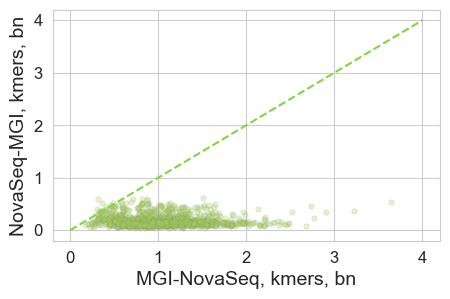

In [165]:
plt.figure(figsize=(5,3))    
sns.scatterplot(data=merged, x='BGI_Illumina', y='Illumina_BGI', color='#a5d455', alpha=0.3, s=15, edgecolor='grey')
plt.plot([0,4e9], [0, 4e9], c='#81d640', ls='--')
plt.xlabel('MGI-NovaSeq, kmers, bn', fontdict={'fontsize': 14})
plt.ylabel('NovaSeq-MGI, kmers, bn', fontdict={'fontsize': 14})
plt.xticks([0,1e9,2e9,3e9,4e9], [0,1,2,3,4], fontdict={'fontsize': 12})
plt.yticks([0,1e9,2e9,3e9,4e9], [0,1,2,3,4], fontdict={'fontsize': 12})

plt.savefig("results/Figure_5/Fig5c.png", dpi=300, bbox_inches='tight')
plt.savefig("results/Figure_5/Fig5c.svg", bbox_inches='tight')

plt.show()